# *PREDICTING FUTURE DEMAND [Kaggle Challenge]*

## Executive Summary

### In this analysis, we'll be looking at methods to predict future demand represented by monthly sales from previous data. This analysis can bring benefit to the business in many aspect including inventory management and a better understanding on the market behaviour.

## Peeking at the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns

In [2]:
df_sales = pd.read_csv('./data/sales_train.csv')
print('shapes: ', df_sales.shape)
df_sales.head()

shapes:  (2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
df_shops = pd.read_csv('./data/shops.csv')
print('shapes: ', df_shops.shape)
df_shops.head()

shapes:  (60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [4]:
df_items = pd.read_csv('./data/items.csv')
print('shapes: ', df_items.shape)
df_items.head()

shapes:  (22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
df_item_cat = pd.read_csv('./data/item_categories.csv')
print('shapes: ', df_item_cat.shape)
df_item_cat

shapes:  (84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [ ]:
df = pd.merge(left = df_sales, right = df_shops, left_on='shop_id', right_on='shop_id')
df = pd.merge(left = df, right = df_items, left_on = 'item_id', right_on = 'item_id')
df = pd.merge(left = df, right = df_item_cat, left_on = 'item_category_id', right_on = 'item_category_id')
df['date'] = ([datetime.strptime(x, "%d.%m.%Y") for x in df.iloc[:, 0]])
df.head(4)

In [ ]:
# 2935849 before
df.info()

In [ ]:
# So I'dont have to redo the date part which is time consuming
df.to_csv(path_or_buf='./data/data_draft.csv')

## Exploratory Data Analysis

In [5]:
df = pd.read_csv('./data/data_draft.csv')
df = df.groupby(['date_block_num','shop_id' ,'item_id']).agg(monthly_sales = pd.NamedAgg(column='item_cnt_day', aggfunc='sum')).reset_index()
df['monthly_sales'].clip(0, 20, inplace = True)

In [3]:
df = df[df['date_block_num'] > 32]

Text(0.5, 1.0, 'Sales of a product Relative to Shop Id')

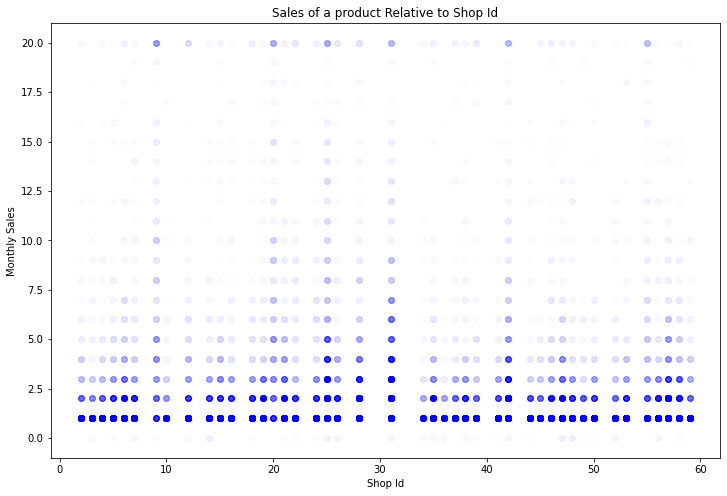

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
plt.plot(df['shop_id'], df['monthly_sales'], 'bo',  alpha = 0.01)
plt.xlabel('Shop Id')
plt.ylabel('Monthly Sales')
plt.title('Sales of a product Relative to Shop Id')

In [ ]:
# price = df.groupby(['shop_id' ,'item_id']).agg(avg_price = pd.NamedAgg(column='item_price', aggfunc='mean')).reset_index()
# price.head()

In [ ]:
# df = pd.merge(df, price, how = 'left', left_on = ['shop_id' ,'item_id'], right_on = ['shop_id' ,'item_id'])

In [ ]:
df['monthly_sales'].plot(kind = 'box')

## Machine Learning 

In [5]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor as gbm

In [6]:
X = df.drop(['monthly_sales'], axis = 1)
y = df['monthly_sales']
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [11]:
xgb_fit = gbm(max_depth = 5, n_estimators=500, random_state = 0, ).fit(X_train, y_train)

[15:58:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [12]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

predict_xgb = xgb_fit.predict(X_test)
predict_xgb = pd.Series([int(val) for val in predict_xgb])
predict_xgb.index = y_test.index
print('RMSE: {}'.format(mse(y_test.values, predict_xgb.values)**0.5))
print('R2_Score: {}'.format(r2_score(y_test.values, predict_xgb.values)))

RMSE: 1.8743005799391999
R2_Score: 0.4502847677751687


In [10]:
from sklearn.ensemble import RandomForestRegressor as rfr

rfr_fit = rfr().fit(X_train, y_train)

predict_rfr = rfr_fit.predict(X_test)
predict_rfr = pd.Series([int(val) for val in predict_rfr])
predict_rfr.index = y_test.index

print('RMSE: {}'.format(mse(y_test.values, predict_rfr.values)**0.5))
print('R2_Score: {}'.format(r2_score(y_test.values, predict_rfr.values)))

RMSE: 1.9897300700390002
R2_Score: 0.3804910019678345


## Evaluating Time Series Algorithm

In [6]:
# Since we'll be predicting monthly sales, I figured we should first look at our data to see
# what the monthly sales looked like.

gb = df.groupby('date_block_num').agg(monthly_sales = pd.NamedAgg(column='item_cnt_day', aggfunc='sum'))
gb.plot()
plt.xlabel('months')
plt.ylabel('Sales(unit)')
plt.title('Sales by month');

KeyError: "Column 'item_cnt_day' does not exist!"

In [ ]:
# In this section I converted 'date_block_num' variable into date type so we can further
# analyze it using time series algorithm.

from datetime import datetime, timedelta
from collections import OrderedDict

def monthlist_fast(dates):
    start, end = [datetime.strptime(_, "%Y-%m-%d") for _ in dates]
    total_months = lambda dt: dt.month + 12 * dt.year
    mlist = []
    for tot_m in range(total_months(start)-1, total_months(end)):
        y, m = divmod(tot_m, 12)
        mlist.append(datetime(y, m+1, 1))#.strftime("%b-%y"))
    return mlist

dates = ["2013-01-02", "2015-10-18"]

gb['date_block_num'] = monthlist_fast(dates)
gb.set_index('date_block_num', inplace = True)
gb.head(6)

In [ ]:
# https://medium.com/better-programming/a-visual-guide-to-time-series-decomposition-analysis-a1472bb9c930
# https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

import statsmodels.api as sm
from pylab import rcParams

rcParams['figure.figsize'] = 12, 8

decomposition = sm.tsa.seasonal_decompose(gb, model='additive')
fig = decomposition.plot()
plt.tight_layout()

plt.show()

- The trend section showed us that the sales of the prodcut decrease from 2013 to 2015 in a almost linear fashion.
- Based on the decomposition, we can see that there are strong seasonal pattern which increase product sales at around the end of the year. 
- Resid showed us the value after seasonality and trend was removed. based on the graph, the residuals variate between -5000 to 10000. Which is fairly large. 

In [ ]:
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
gb

In [ ]:
gb.index = pd.DatetimeIndex(gb.index.values,
                               freq=gb.index.inferred_freq)

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(gb,
                                            order=param,
                                          b  seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [ ]:
mod = sm.tsa.statespace.SARIMAX(gb,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics()
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = gb['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Unit Sales')
plt.legend()
plt.show()

## Predicting Future Sales

In [ ]:
test = pd.read_csv('./data/test.csv')
test.head(6)

In [ ]:
test['date_block_num'] = 34
test = test[['ID', 'date_block_num', 'shop_id', 'item_id']]
test

In [ ]:
result = pd.DataFrame(xgb_fit.predict(test.drop(['ID'], axis = 1)))
result.head(6)

In [ ]:
ans = pd.concat([test, result], axis = 1)
ans.rename(columns={0: 'item_cnt_month'}).loc[:,['ID', 'item_cnt_month']].set_index('ID').to_csv('../Future Demand/answer.csv')

In [ ]:
pd.read_csv('../Future Demand/answer.csv')